In [1]:
from Bio import Entrez, SeqIO
from matplotlib import pyplot

def getSequencesFromFile(filePath):
    """
    Reads the FASTA file at the specified filePath and returns the sequences within it.

    Parameters:
        filePath - a path to the file you want to read
    Returns:
        A list of strings containing each of the sequences in the specied file
    """
    with open(filePath) as handle:
        sequenceStrings = []
        records = SeqIO.parse(handle, "fasta")
        for record in records:
            sequenceStrings.append(str(record.seq))

    return sequenceStrings

def getSequencesFromNCBI(databaseName, accessionId):
    """
    Downloads the specified record from the NCBI and returns the sequences within it.

    Parameters:
        databaseName - the name of the NCBI database to download from, i.e. "protein" or "nucleotide"
        accessionId - the accession number/id of the specified record, i.e. "NM_000280.4"
    Returns:
        A list of strings containing each of the sequences in the specied file
    """
    with Entrez.efetch(db=databaseName, id=accessionId, rettype="fasta", retmode="text") as handle:
        sequenceStrings = []
        records = SeqIO.parse(handle, "fasta")
        for record in records:
            sequenceStrings.append(str(record.seq))

    return sequenceStrings

def dotplot(sequenceA, sequenceB, windowSize):
    """
    Creates a dotplot showing substrings in sequenceA and sequenceB that are identical.

    Parameters:
        sequenceA - a string containing the first sequence to compare
        sequenceB - a string containing the second sequence to compare
        windowSize - the length of substrings to compare in each sequence
    Returns:
        Nothing.
        However, a dotplot will shown in a new window created by matplotlib,
            with position in sequenceA on the x-axis and position in sequenceB on the y-axis.
        This function will block until the dotplot window is closed.
    """
    xList = []
    yList = []
    maxIndexA = len(sequenceA) - windowSize + 1
    maxIndexB = len(sequenceB) - windowSize + 1
    for indexA in range(maxIndexA):
        # Iterate throught every substring of length windowSize in sequenceA
        substringA = sequenceA[indexA:indexA+windowSize]
        for indexB in range(maxIndexB):
            # Iterate throught every substring of length windowSize in sequenceB
            substringB = sequenceB[indexB:indexB+windowSize]
            if substringA == substringB:
                xList.append(indexA)
                yList.append(indexB)

    # Use matplotlib to create a scatter plot of all of the points where the sequences match.
    pyplot.scatter(xList, yList)
    pyplot.axis([0, maxIndexA, 0, maxIndexB])
    pyplot.show()

    
    
def globalAlignment(s, t, substitutionMatrix, indelPenalty):
    """
    """

    # TODO s is the column, t is the row

    # Set up the scores and paths lists
    scores = []
    paths = []
    for _ in range(len(s)+1):
        thisScoresRow = []
        thisPathsRow = []
        for _ in range(len(t)+1):
            thisScoresRow.append(0)
            thisPathsRow.append("")
        scores.append(thisScoresRow)
        paths.append(thisPathsRow)

    # The top left corner should be initialized with a score of 0 and a path of ""

    # Compute the top row of scores, excluding the top left corner
    for tPos in range(1, len(t)+1):
        scores[0][tPos] = scores[0][tPos-1] + indelPenalty
        paths[0][tPos] = "L"

    # Compute the left row of scores, excluding the top left corner
    for sPos in range(1, len(s)+1):
        scores[sPos][0] = scores[sPos-1][0] + indelPenalty
        paths[sPos][0] = "U"

    # Compute the rest of the scores, based on the previous values in the scores 2D list
    # We'll calculate the first row, from left to right, followed by the 2nd row, and so on.
    for sPos in range(1, len(s)+1):
        for tPos in range(1, len(t)+1):
            scoreFromLeft = scores[sPos][tPos-1] + indelPenalty
            scoreFromUp = scores[sPos-1][tPos] + indelPenalty
            sChar = s[sPos-1]
            tChar = t[tPos-1]
            scoreFromDiagonal = scores[sPos-1][tPos-1] + substitutionMatrix[sChar,tChar]

            # In the case of a tie, we prefer mismatches/matches to indels.
            if scoreFromDiagonal >= scoreFromLeft and scoreFromDiagonal >= scoreFromUp:
                # scoreFromDiagonal is biggest
                scores[sPos][tPos] = scoreFromDiagonal
                paths[sPos][tPos] = "D"
            elif scoreFromLeft >= scoreFromUp:
                # scoreFromLeft is biggest
                scores[sPos][tPos] = scoreFromLeft
                paths[sPos][tPos] = "L"
            else:
                # scoreFromUp is biggest
                scores[sPos][tPos] = scoreFromUp
                paths[sPos][tPos] = "U"

    # Work backward through the paths 2D list to reconstruct the alignment.
    sAlignment = ""
    tAlignment = ""
    sPos = len(s)
    tPos = len(t)
    while not (sPos == 0 and tPos == 0):
        if paths[sPos][tPos] == "D":
            sAlignment = s[sPos-1] + sAlignment
            tAlignment = t[tPos-1] + tAlignment
            sPos -= 1
            tPos -= 1
        elif paths[sPos][tPos] == "L":
            sAlignment = "-" + sAlignment
            tAlignment = t[tPos-1] + tAlignment
            tPos -= 1
        else: # paths[sPos][tPos] == "U"
            sAlignment = s[sPos-1] + sAlignment
            tAlignment = "-" + tAlignment
            sPos -= 1

    maxScore = scores[len(s)][len(t)]

    return maxScore, [sAlignment, tAlignment]

def localAlignment(s, t, substitutionMatrix, indelPenalty):
    """
    """

    # TODO s is the column, t is the row

    # Set up the scores and paths lists
    scores = []
    paths = []
    for _ in range(len(s)+1):
        thisScoresRow = []
        thisPathsRow = []
        for _ in range(len(t)+1):
            thisScoresRow.append(0)
            thisPathsRow.append("")
        scores.append(thisScoresRow)
        paths.append(thisPathsRow)

    # The top left corner should be initialized with a score of 0 and a path of ""

    # A blank entry in the paths 2D list indicates the start point for local alignment

    # Compute the rest of the scores, based on the previous values in the scores 2D list
    # We'll calculate the first row, from left to right, followed by the 2nd row, and so on.
    for sPos in range(1, len(s)+1):
        for tPos in range(1, len(t)+1):
            scoreFromStartingNewSequence = 0
            scoreFromLeft = scores[sPos][tPos-1] + indelPenalty
            scoreFromUp = scores[sPos-1][tPos] + indelPenalty
            sChar = s[sPos-1]
            tChar = t[tPos-1]
            scoreFromDiagonal = scores[sPos-1][tPos-1] + substitutionMatrix[sChar,tChar]

            # In the case of a tie, we prefer mismatches/matches to indels.
            if scoreFromDiagonal >= scoreFromLeft and scoreFromDiagonal >= scoreFromUp and scoreFromDiagonal >= scoreFromStartingNewSequence:
                # scoreFromDiagonal is biggest
                scores[sPos][tPos] = scoreFromDiagonal
                paths[sPos][tPos] = "D"
            elif scoreFromLeft >= scoreFromUp and scoreFromLeft >= scoreFromStartingNewSequence:
                # scoreFromLeft is biggest
                scores[sPos][tPos] = scoreFromLeft
                paths[sPos][tPos] = "L"
            elif scoreFromUp >= scoreFromStartingNewSequence:
                # scoreFromUp is biggest
                scores[sPos][tPos] = scoreFromUp
                paths[sPos][tPos] = "U"
            else:
                # scoreFromStartingNewSequence is biggest, so let's start a new sequence
                scores[sPos][tPos] = scoreFromStartingNewSequence
                paths[sPos][tPos] = ""

    # Find the point in the scores 2D list with the highest score:
    highestScore = -1
    highestScoreSPos = -1
    highestScoreTPos = -1
    for sPos in range(0, len(s)+1):
        for tPos in range(0, len(t)+1):
            if scores[sPos][tPos] > highestScore:
                highestScore = scores[sPos][tPos]
                highestScoreSPos = sPos
                highestScoreTPos = tPos

    # Work backward through the paths 2D list to reconstruct the alignment.
    sAlignment = ""
    tAlignment = ""
    sPos = highestScoreSPos
    tPos = highestScoreTPos
    while not (paths[sPos][tPos] == ""):
        if paths[sPos][tPos] == "D":
            sAlignment = s[sPos-1] + sAlignment
            tAlignment = t[tPos-1] + tAlignment
            sPos -= 1
            tPos -= 1
        elif paths[sPos][tPos] == "L":
            sAlignment = "-" + sAlignment
            tAlignment = t[tPos-1] + tAlignment
            tPos -= 1
        else: # paths[sPos][tPos] == "U"
            sAlignment = s[sPos-1] + sAlignment
            tAlignment = "-" + tAlignment
            sPos -= 1

    startPos = (sPos, tPos)
    endPos = (highestScoreSPos, highestScoreTPos)
    return highestScore, [sAlignment, tAlignment], startPos, endPos

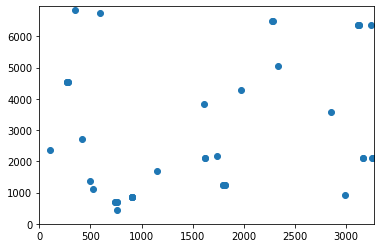

In [2]:
from Bio import Entrez, SeqIO

import compbio

def main():
    Entrez.email = "reiche_n1@denison.edu"

    eyelessProtein = compbio.getSequencesFromNCBI("protein", "NP_524628.2")[0]
    eyelessmRNA = compbio.getSequencesFromNCBI("nucleotide", "NM_079889.3")[0]
    eyelessGenomeDNA = compbio.getSequencesFromFile("eyeless_genomic_sequence.fasta")[0]

    pax6Protein = compbio.getSequencesFromNCBI("protein", "1902328A")[0]
    pax6mRNA = compbio.getSequencesFromNCBI("nucleotide", "NM_000280.4")[0]
    pax6GenomeDNA = compbio.getSequencesFromFile("PAX6_genomic_sequence.fasta")[0]

    #compbio.dotplot(eyelessProtein, pax6Protein, 4)
    compbio.dotplot(eyelessmRNA, pax6mRNA, 10)

    indelPenalty = -1
    basicDNASubstitutionMatrix = {
            ('A','A'):  1, ('A','C'): -1, ('A','G'): -1, ('A','T'): -1,
            ('C','A'): -1, ('C','C'):  1, ('C','G'): -1, ('C','T'): -1,
            ('G','A'): -1, ('G','C'): -1, ('G','G'):  1, ('G','T'): -1,
            ('T','A'): -1, ('T','C'): -1, ('T','G'): -1, ('T','T'):  1,
    }
    score, [eyelessAlignment, pax6Alignment] = compbio.globalAlignment(eyelessmRNA, pax6mRNA, basicDNASubstitutionMatrix, indelPenalty)
    #print(f"mRNA alignment score: {score}")
    #print(eyelessAlignment[:120])
    #print(pax6Alignment[:120])

main()


